[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5)]


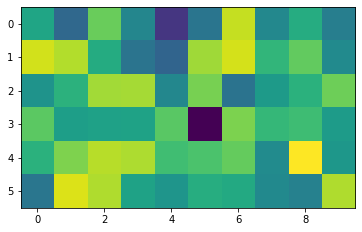

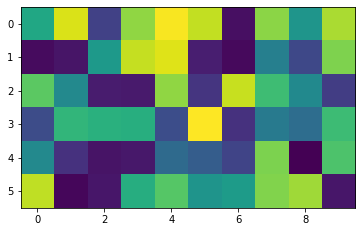

In [753]:
import pickle

from scipy.spatial.distance import minkowski, directed_hausdorff
import itertools

from matplotlib import pyplot as plt
from typing import Union, Generator, Optional, NoReturn
import numpy as np

def convolutional_generator(
        matrix: np.ndarray,
        filter_size: Union[int, tuple[int, int]],
        stride: Optional[Union[int, tuple[int, int]]]=(1, 1),
        padding: Optional[Union[int, tuple[int, int]]] = (0, 0),
        x_labels: Optional[list[Union[int, str]]] = None,
        y_labels: Optional[list[Union[int, str]]] = None
) -> Generator[tuple[Union[int, str], Union[int, str], np.ndarray], None, NoReturn]:
    if x_labels is not None and matrix.shape[1] != len(x_labels):
        raise ValueError(f'Shape and labels does not match: shape[1]: {matrix.shape[1]}, x_labels: {len(x_labels)}')
    if y_labels is not None and matrix.shape[0] != len(y_labels):
        raise ValueError(f'Shape and labels does not match: shape[0]: {matrix.shape[0]}, x_labels: {len(y_labels)}')
    if isinstance(filter_size, int):
        filter_size = (filter_size, filter_size)
    if isinstance(stride, int):
        stride = (stride, stride)
    if isinstance(padding, int):
        padding = (padding, padding)
    if matrix.ndim == 2:
        matrix = np.pad(matrix, ((padding[0], padding[0]), (padding[1], padding[1])))
    elif matrix.ndim == 3:
        slices = [matrix[:, :, i] for i in range(matrix.shape[-1])]
        for i in range(len(slices)):
            slices[i] = np.pad(slices[i], ((padding[0], padding[0]), (padding[1], padding[1]))).T
        matrix = np.array(slices).T
    else:
        raise ValueError(f'Wrong number of dimensions: {matrix.ndim}. Only ndim=2 and ndim=3 are supported')
    i = 0
    j = 0
    for _0 in range(matrix.shape[0]):
        for _1 in range(matrix.shape[1]):
            if i <= matrix.shape[0] and j <= matrix.shape[1]:
                if i < matrix.shape[0]:
                    if i + filter_size[0] <= matrix.shape[0]:
                        i_edge = i + filter_size[0]
                    else:
                        i_edge = i + matrix.shape[0] - filter_size[0]
                else:
                    i_edge = matrix.shape[0] - 1
                if j < matrix.shape[1]:
                    if j + filter_size[1] <= matrix.shape[1]:
                        j_edge = filter_size[1]
                    else:
                        j_edge = matrix.shape[1] - j
                else:
                    j_edge = matrix.shape[1] - 1
                if matrix.ndim == 2:
                    out = matrix[i:i_edge, j:j+j_edge]
                else:
                    out = matrix[i:i_edge, j:j+j_edge, :]
                y_edges = (i, i_edge - 1) if x_labels is None else (y_labels[i], y_labels[i_edge - 1])
                x_edges = (j, j + j_edge - 1) if x_labels is None else (x_labels[j], x_labels[j + j_edge - 1])
                yield x_edges, y_edges, out
                j += stride[1]
            else:
                break
        i += stride[0]
        j = 0

def ssd_pool(
        matrix: np.ndarray,
        filter_size: Union[int, tuple[int, int]],
        stride: Optional[Union[int, tuple[int, int]]]=(1, 1),
        padding: Optional[Union[int, tuple[int, int]]] = (0, 0),
        x_labels: Optional[list[Union[int, str]]] = None,
        y_labels: Optional[list[Union[int, str]]] = None
) -> tuple[list[tuple[int, int]], list[tuple[int, int]], np.ndarray]:
    y_prev = None
    A = list()
    row = list()
    x_labels_out = list()
    y_labels_out = list()
    initial = True
    for i, shape in enumerate(convolutional_generator(matrix, filter_size, stride, padding, x_labels, y_labels)):
        x, y, shape = shape
        x_labels_out.append(x)
        y_labels_out.append(y)
        if initial:
            y_prev = y
            initial = False
        ssds = list()
        for j in range(shape.shape[-1]):
            for k in range(shape.shape[-1]):
                # ssds.append(np.sum((shape[:, :, j] - shape[:, :, k]))**2)
                ssds.append(np.linalg.norm((shape[:, :, j] - shape[:, :, k]))**2)
        res = sum(ssds)/len(ssds)
        if y == y_prev:
            row.append(res)
        else:
            A.append(np.array(row))
            row = [res]
        y_prev = y
    A.append(np.array(row))
    return x_labels_out, y_labels_out, np.array(A)

def zero_one_sigmoid(x: Union[float, np.ndarray], threshold: float, infinitesimal=1e-5) -> np.array:
    k = threshold/np.log(infinitesimal**-1)
    return 1/(1 + np.exp((x - threshold)/k))

np.random.seed(0)
matrix = np.random.rand(6,10,25)
x, y, A = ssd_pool(matrix, 1, 1)
print(x)
print(y)
mean = A.mean() if isinstance(A.mean(), float) else A.mean().mean()
plt.imshow(A)
plt.show()
# plt.imshow(A**-1)
# plt.show()
plt.imshow(zero_one_sigmoid(A, mean))
plt.show()

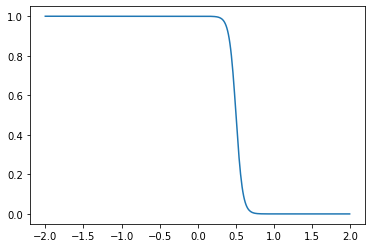

In [393]:
x = np.arange(-2, 2, .01)
err = 1e-5
# k = 1
# n = k*np.log(1/err)
n = .5
k = n/np.log(1/err)
y = 1/(1 + np.exp((x - n)/k))
plt.plot(x, y)
plt.show()

SSD
A, A:  0.0 0.99999
A, A-1:  159.91346438064627 0.0
A, B0:  0.30057206462452823 0.61846
A, B1:  0.10400765919978265 0.99957
A, B2:  0.12024449305686719 0.99923
A, B3:  0.04761523592987027 0.99994
A, B4:  0.006454109958291253 0.99999
A, C:  0.28167122217170176 0.74193
A, D:  1.555232303601198 0.0
C, D:  1.2168053919985633 0.0
A


/tmp/ipykernel_50888/1715847397.py:106: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp((x - threshold)/k))


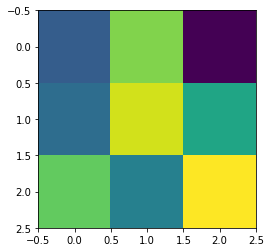

A-1


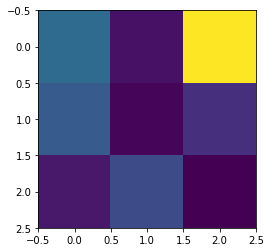

B0


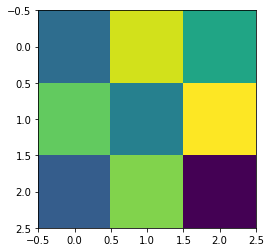

B1


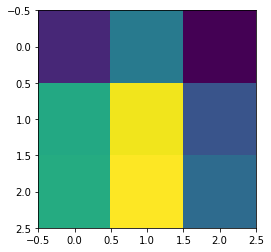

B2


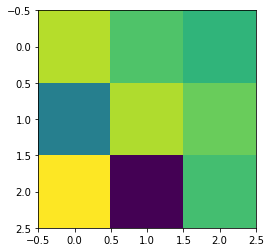

B3


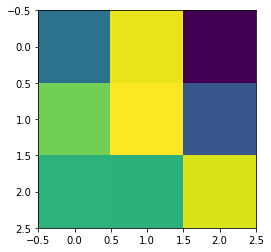

B4


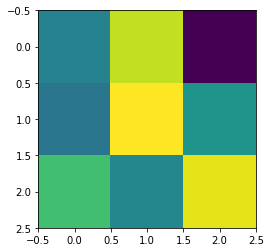

C


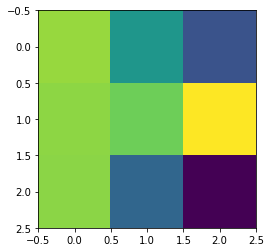

D


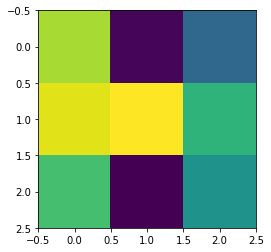

In [754]:
from scipy.spatial.distance import chebyshev, cdist

# A = np.array([
#     np.array([0.5, 1.5, 0.3]),
#     np.array([0.4, 2.5, 1.3]),
#     np.array([2.1, 0.5, 0.2]),
# ])
A = np.random.rand(3, 3)
A = A/np.linalg.norm(A)
A_inv = A**-1


B0 = A.copy()
np.random.shuffle(B0)
# B0 = B0/np.linalg.norm(B0)
B1 = A@np.random.rand(3, 3)
B1 = B1/np.linalg.norm(B1)
B2 = A + np.random.rand(3, 3)
B2 = B2/np.linalg.norm(B2)
B3 = A + np.random.rand(3, 3)/2
B3 = B3/np.linalg.norm(B3)
B4 = A + np.random.rand(3, 3)/10
B4 = B4/np.linalg.norm(B4)

C = np.random.rand(3, 3)
C = C/np.linalg.norm(C)

D = np.random.rand(3, 3)
D/np.linalg.norm(D)

def z_o_sigm_matrices(A, B):
    ssd = np.sum((A - B)**2)
    thr = np.mean(
        np.array([
            A.mean().mean(), B.mean().mean()
        ])
    )
    return np.round(zero_one_sigmoid(ssd, thr), 5)

print('SSD')
print('A, A: ', np.sum((A - A)**2), z_o_sigm_matrices(A, A))
print('A, A-1: ', np.sum((A - A**-1)**2), z_o_sigm_matrices(A, A**-1))
print('A, B0: ', np.sum((A - B0)**2), z_o_sigm_matrices(A, B0))
print('A, B1: ', np.sum((A - B1)**2), z_o_sigm_matrices(A, B1))
print('A, B2: ', np.sum((A - B2)**2), z_o_sigm_matrices(A, B2))
print('A, B3: ', np.sum((A - B3)**2), z_o_sigm_matrices(A, B3))
print('A, B4: ', np.sum((A - B4)**2), z_o_sigm_matrices(A, B4))
print('A, C: ', np.sum((A - C)**2), z_o_sigm_matrices(A, C))
print('A, D: ', np.sum((A - D)**2), z_o_sigm_matrices(A, D))
print('C, D: ', np.sum((C - D)**2), z_o_sigm_matrices(C, D))

for m, n in zip([A, A_inv, B0, B1, B2, B3, B4, C, D],
                ['A', 'A-1', 'B0', 'B1', 'B2', 'B3', 'B4', 'C', 'D']):
    print(n)
    plt.imshow(m)
    plt.show()
    pass

In [756]:
import os
import pickle
from cross_runs_TF_planes import CrossRunsTFScorer

subjects_dir = os.path.join('../', 'Source', 'Subjects')
tf_scorers = dict()
for subject in os.listdir(subjects_dir):
    tf_planes_path = os.path.join(subjects_dir, subject, 'TF_planes')
    for session in os.listdir(tf_planes_path):
        cor_path = os.path.join(tf_planes_path, session, 'RespCor')
        if session not in tf_scorers:
            tf_scorers.update({session: dict()})
        for case in os.listdir(cor_path):
            case_name = case[:-4]
            if case_name in tf_scorers[session]:
                tf_scorers[session][case_name].append(
                    pickle.load(open(
                        os.path.join(cor_path, case),
                        'rb'
                    ))
                )
            else:
                tf_scorers[session].update({
                    case_name: [
                        pickle.load(open(
                            os.path.join(cor_path, case),
                            'rb'
                        ))
                    ]
                })

In [629]:
from mne import create_info
from mne.time_frequency import AverageTFR
from utils.data_management import dict2str
n = 2
arr = np.arange(10)
print(len(arr)//n)
arr = arr.reshape(arr.shape[0], 1)

for _, _, val in convolutional_generator(arr, n, n+2):
    print(val.reshape(-1))

5
[0 1]
[4 5]
[8 9]


lm_vs_li B1
No baseline correction applied


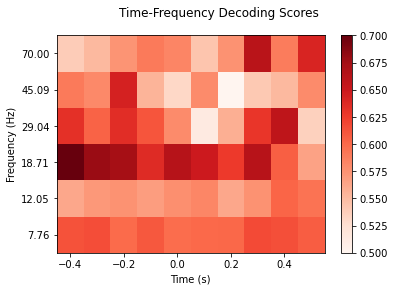

No baseline correction applied


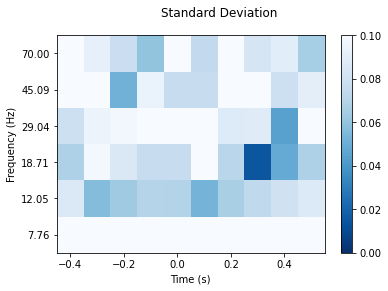

No baseline correction applied


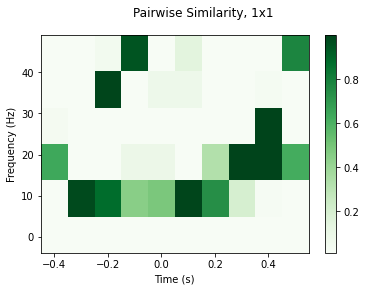

left_vs_right B1
No baseline correction applied


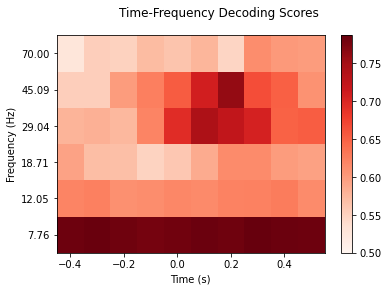

No baseline correction applied


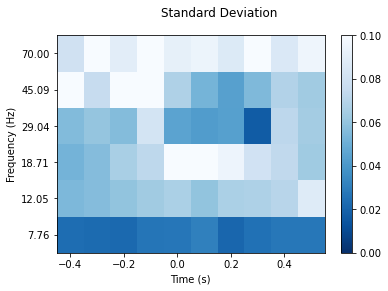

No baseline correction applied


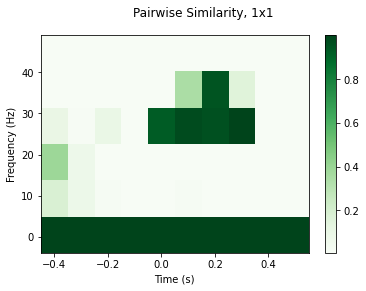

rm_vs_ri B1
No baseline correction applied


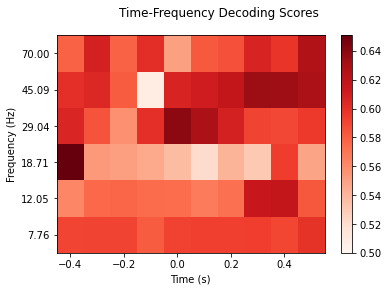

No baseline correction applied


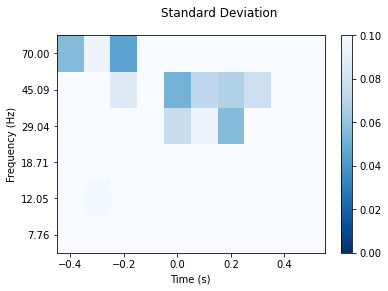

No baseline correction applied


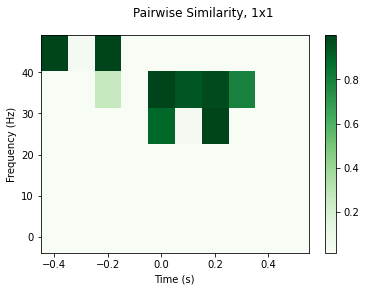

lm_vs_li B10
No baseline correction applied


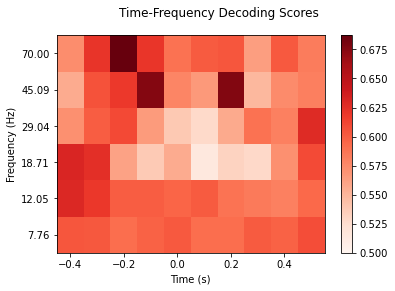

No baseline correction applied


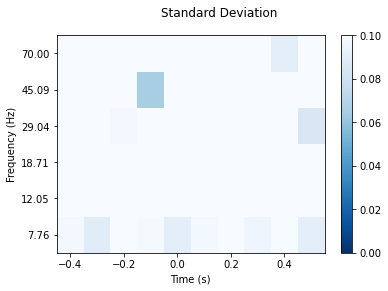

No baseline correction applied


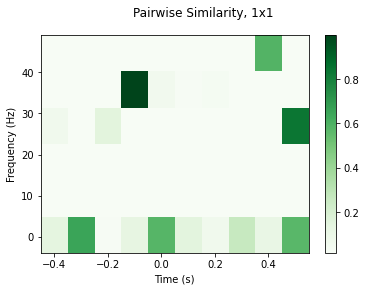

left_vs_right B10
No baseline correction applied


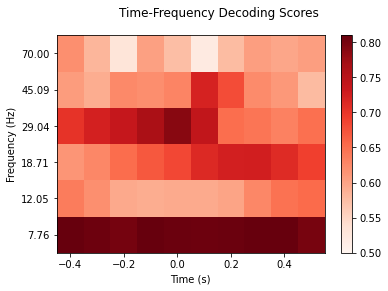

No baseline correction applied


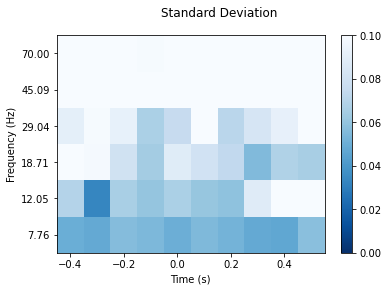

No baseline correction applied


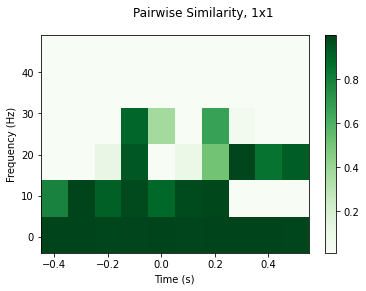

rm_vs_ri B10
No baseline correction applied


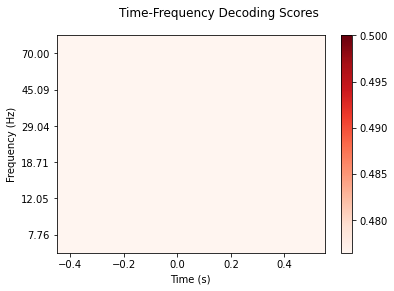

No baseline correction applied


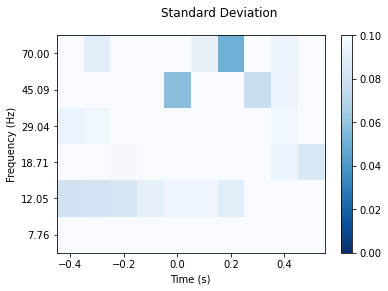

No baseline correction applied


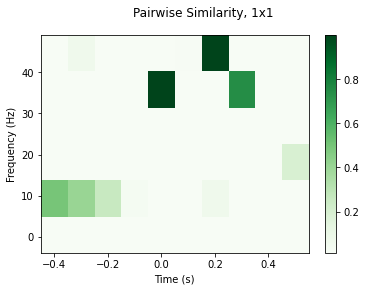

In [757]:
import matplotlib

tmin, tmax = -.500, .500
n_cycles = 14
min_freq = 5.
max_freq = 70.
n_freqs = 7
freqs_range = np.logspace(np.log10(min_freq), np.log10(max_freq), n_freqs)
window_spacing = (n_cycles / np.max(freqs_range) / 2.)
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]

tf_planes = {
    session: {
        case: np.array([tfs.tf_scores.mean(axis=0).T for tfs in tf_scorers[session][case]]).T
        for case in tf_scorers[session]
    }
    for session in tf_scorers
}
# print(dict2str(tf_planes))

# A = tf_planes['B1']['lm_vs_li'][:, :, 2]
# plt.imshow(A)
# plt.show()

for session, cases in tf_planes.items():
    for case, planes in cases.items():
        m, n = (1, 1), (1, 1)
        freqs = [0.0] + list(freqs_range[1:])
        # print(x)
        # print(y)
        # print([i for i in range(len(freqs))])
        # print([i for i in range(len(centered_w_times))])
        new_freqs = sorted([np.round(
            (freqs[i%len(freqs)] + freqs[j%len(freqs)])/2, 2
        ) for i, j in set(y)])
        new_times = sorted([np.round(
            (centered_w_times[i%len(centered_w_times)] + centered_w_times[j%len(centered_w_times)])/2, 2
        ) for i, j in set(x)])
        # print(sorted(new_times))
        # print(sorted(new_freqs))
        x, y, A = ssd_pool(planes, m, n)
        # print(planes.shape, A.shape, len(new_freqs), len(new_times))
        thr = A.mean().mean()*0.5
        A_corr = zero_one_sigmoid(A, thr)
        print(case, session)
        av_tfr = AverageTFR(create_info(['freq'], 1000), planes.mean(axis=2)[np.newaxis, :],
                    centered_w_times, freqs_range[1:], 1)
        av_tfr.plot([0], vmin=.5, title="Time-Frequency Decoding Scores",
            cmap=plt.cm.Reds)
        av_tfr = AverageTFR(create_info(['freq'], 1000), planes.std(axis=2)[np.newaxis, :],
                    centered_w_times, freqs_range[1:], 1)
        av_tfr.plot([0], vmin=0e0, vmax=.1, title="Standard Deviation",
            cmap=matplotlib.cm.get_cmap('Blues_r'))
        # plt.imshow(planes.mean(axis=2)[::-1, :])
        # plt.xticks([i for i in range(len(new_times))], new_times)
        # plt.yticks([i for i in range(len(freqs))], sorted(np.round(freqs, 2), reverse=True))
        # plt.show()
        # plt.imshow(A)
        # plt.xticks([i for i in range(len(new_times))], new_times)
        # plt.yticks([i for i in range(len(new_freqs))], new_freqs)
        # plt.show()
        # plt.imshow(A_corr[::-1, :])
        # plt.xticks([i for i in range(len(new_times))], new_times)
        # plt.yticks([i for i in range(len(new_freqs))], sorted(new_freqs, reverse=True))
        # plt.show()
        av_tfr = AverageTFR(create_info(['freq'], 1000), A_corr[np.newaxis, :],
                    new_times, new_freqs, 1)
        av_tfr.plot([0], vmin=thr, title="Pairwise Similarity, 1x1",
            cmap=plt.cm.Greens)
# To check:Az_Mar_05 lm_vs_li
# av_tfr = AverageTFR(create_info(['freq'], 1000), A[np.newaxis, :],
#                     centered_w_times, freqs_range[1:], 1)
# chance = .5  # set chance level to white in the plot
# av_tfr.plot([0], vmin=chance, title="Time-Frequency Decoding Scores",
#             cmap=plt.cm.Reds)